# Network analyisis

This notebook tackles the creation of networks according to different periods in time, then an analysis of each is carried out. 

In [1]:
# Dependencies
from modules.network import WordsNet, HashNet
from modules.dataset.tweets import Tweets
from modules.dataset.entities import Entities
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Set up default colors
import matplotlib.colors as mc
colors=[*mc.TABLEAU_COLORS.values()]

In [3]:
# Constants
TWEETS_DB_PATH = 'data/db/tweets.json'  # Path to tweets dataset
WORDS_DB_PATH = 'data/db/words.json'  # Path to words dataset
HASHTAGS_DB_PATH = 'data/db/hashtags.json'  # Path to hashtags dataset

In [4]:
# Define networks container, indexed by periods
networks = {
    2017: None,
    2018: None,
    2019: None
}

In [5]:
# Import tweets dataset
tweets = Tweets()
tweets.from_json(TWEETS_DB_PATH)
tweets.df.head()

,tweet_id,tweet_date,tweet_text
0,836950901495631872,2017-03-01 14:46:59,TT SINGAPORE 22:46\n1.Hong Kong\n2.#JointAddre...
1,836950882528989184,2017-03-01 14:46:54,Letting #snapchat prepare me for the day's uns...
2,836950869639835649,2017-03-01 14:46:51,"""The bill would require the state to get all o..."
3,836950847380668416,2017-03-01 14:46:46,Style-Lead don't Follow #recycledfashion https...
4,836950839101116421,2017-03-01 14:46:44,‘Shell knew’: oil giant's 1991 film warned of ...


In [6]:
tweets.df.shape

(14425, 3)

In [7]:
# Import hashtags dataset
hashtags = Entities()
hashtags.from_json(HASHTAGS_DB_PATH)
hashtags.df.head()

,tweet_id,entity_index,entity_text,entity_tag,entity_conf
0,1101574442575167489,0,#Humans,#,0.6243
1,1101574442575167489,7,#climatechange,^,0.4925
2,1101574446341607424,27,#ClimateChange,#,0.6968
3,1101574446341607424,36,#ActOnClimate,#,0.7929
4,1101574446341607424,37,#climate,#,0.9559


In [8]:
# Import words dataset
words = Entities()
words.from_json(WORDS_DB_PATH)
words.df.head()

,tweet_id,entity_index,entity_text,entity_tag,entity_conf
0,1101574442575167489,1,frog,N,0.9797
1,1101574442575167489,3,hot,A,0.9848
2,1101574442575167489,4,water,N,0.9996
3,1101574442575167489,6,climate,N,0.9742
4,1101574442575167489,7,change,N,0.9579


In [9]:
networks

{2017: None, 2018: None, 2019: None}

## Preliminary analysis

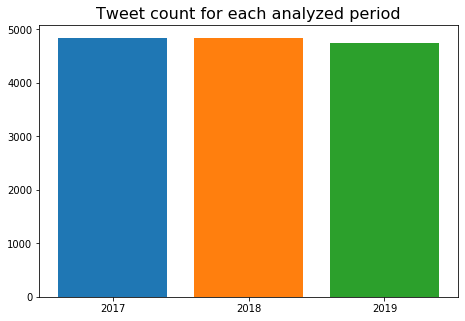

In [10]:
# Number of tweets in each period

# Initialize plot
fig, ax = plt.subplots(figsize=(7.5, 5))
# TODO Set title
_ = ax.set_title('Tweet count for each analyzed period', fontsize=16)
# Loop through each period
for period in networks.keys():
    # Generate an histogram
    _ = ax.bar([str(period)], (tweets.df.tweet_date.dt.year == period).sum())
# Show plot
_ = plt.show()

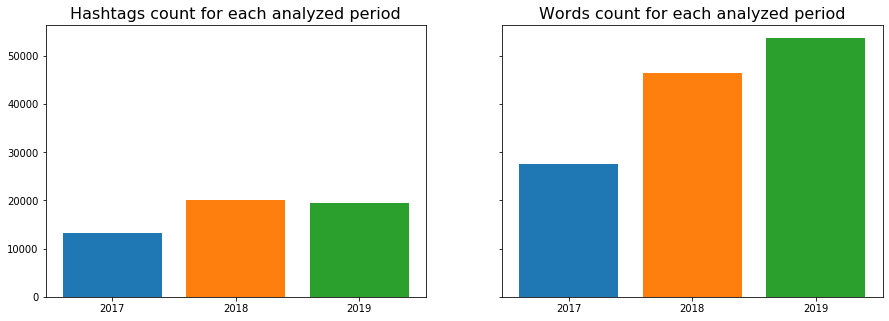

In [11]:
# Number of entities (hashtags and words) for each period

# Initialize plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
# Set titles
_ = axs[0].set_title('Hashtags count for each analyzed period', fontsize=16)
_ = axs[1].set_title('Words count for each analyzed period', fontsize=16)
# Loop through each period
for period in networks.keys():
    # Get tweets for current period
    curr_tweets = tweets.df[tweets.df.tweet_date.dt.year == period]
    # Get tweet ids for current period
    curr_tweets_id = curr_tweets.tweet_id
    # Subset hashtags and words for current period
    curr_hashtags = hashtags.df[hashtags.df.tweet_id.isin(curr_tweets_id)]
    curr_words = words.df[words.df.tweet_id.isin(curr_tweets_id)]
    # Generate hashtags and words barplots
    _ = axs[0].bar([str(period)], [curr_hashtags.shape[0]])
    _ = axs[1].bar([str(period)], [curr_words.shape[0]])
# Show plot
_ = plt.show()

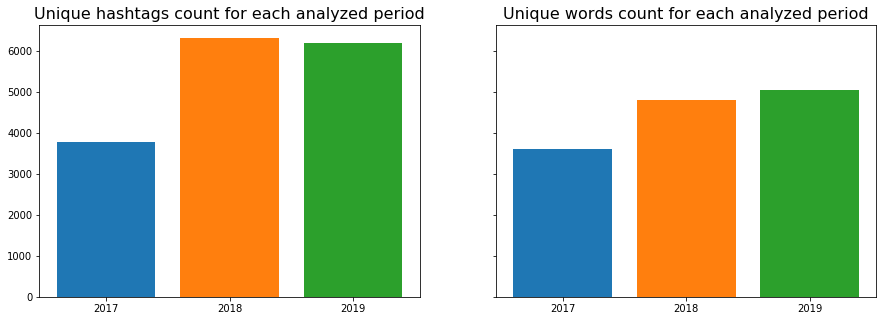

In [12]:
# Number of unique entities (hashtags and words) for each period

# Initialize plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
# Set titles
_ = axs[0].set_title('Unique hashtags count for each analyzed period', fontsize=16)
_ = axs[1].set_title('Unique words count for each analyzed period', fontsize=16)
# Loop through each period
for period in networks.keys():
    # Get tweets for current period
    curr_tweets = tweets.df[tweets.df.tweet_date.dt.year == period]
    # Get tweet ids for current period
    curr_tweets_id = curr_tweets.tweet_id
    # Subset hashtags and words for current period
    curr_hashtags = hashtags.df[hashtags.df.tweet_id.isin(curr_tweets_id)]
    curr_unique_hashtags = curr_hashtags[['entity_text', 'entity_tag']].drop_duplicates()
    curr_words = words.df[words.df.tweet_id.isin(curr_tweets_id)]
    curr_unique_words = curr_words[['entity_text', 'entity_tag']].drop_duplicates()
    # Generate hashtags and words barplots
    _ = axs[0].bar([str(period)], [curr_unique_hashtags.shape[0]])
    _ = axs[1].bar([str(period)], [curr_unique_words.shape[0]])
# Show plot
_ = plt.show()

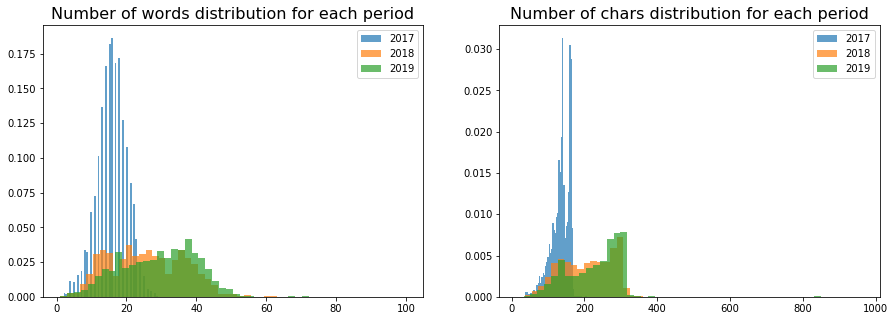

In [13]:
# Tweets lengths for each period, in terms of either number of words and characters

# Compute length of each tweet, in terms of either words and characters
tweets_words_len = tweets.df.tweet_text.apply(lambda text: len(text.split(' ')))
tweets_chars_len = tweets.df.tweet_text.apply(lambda text: len(text))

# Initialize plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# Set titles
_ = axs[0].set_title('Number of words distribution for each period', fontsize=16)
_ = axs[1].set_title('Number of chars distribution for each period', fontsize=16)
# Loop through each period
for period in networks.keys():
    # Get boolean series of current period tweets
    curr_tweets = (tweets.df.tweet_date.dt.year == period)
    # Get words and chars number for current period
    curr_words_len = tweets_words_len[curr_tweets]
    curr_chars_len = tweets_chars_len[curr_tweets]
    # Generate hashtags and words histograms
    _ = axs[0].hist(curr_words_len, bins=50, density=True, alpha=.7)
    _ = axs[1].hist(curr_chars_len, bins=50, density=True, alpha=.7)
# Set legend
_ = axs[0].legend([*networks.keys()])
_ = axs[1].legend([*networks.keys()])
# Show plot
_ = plt.show()

## Network creation

In [14]:
# Create a network for each period

# Defime a statistics container (dictionary)
stats = {}

# Define the list of hashtags used as search seeds
seed_list = ["climatechange", "climate", "sdgs", "sustainability", "environment", "globalwarming"]

# Loop through each period
for period in networks.keys():
    # Subset tweets for current period
    curr_tweets = Tweets()
    curr_tweets.df = tweets.df.loc[tweets.df.tweet_date.dt.year == period].copy()
    # Get ids of tweets for current period
    curr_tweets_id = curr_tweets.df.tweet_id.unique()
    # Subset hashtags and words associated to current tweets
    curr_hashtags, curr_words = Entities(), Entities()
    curr_hashtags.df = hashtags.df.loc[hashtags.df.tweet_id.isin(curr_tweets_id)]
    curr_words.df = words.df.loc[words.df.tweet_id.isin(curr_tweets_id)]
    # Remove seeds from hashtag dataset
    curr_words.df = curr_words.df.loc[~curr_words.df.entity_text.isin(seed_list)]
    # Generate a dictionary containing words and hashtags networks for each period
    networks[period] = {
        'hashtags': HashNet.from_entities(curr_hashtags),
        'words': WordsNet.from_entities(curr_words)
    }
    
    # Initialize statistics container
    stats[period] = {
        'hashtags': {},
        'words': {}
    }

In [15]:
# Check that the networks are connected

for period in networks.keys():
    for net_type in networks[period]:
            # Get the list of connected components sorted by size
            cc = networks[period][net_type].get_connected_components()
            # If there is only one cc
            if len(cc) == 1:
                print("{} {} network is connected".format(period, net_type))
            else:
                # Compute the ratio between the size of the largest cc and the sum of all the cc sizes
                gc_ratio = int(100*cc[0]["size"]/sum([cc[i]["size"] for i in range(len(cc))]))
                # Print results
                print("{} {} network consists in {} connected components".format(period, net_type, len(cc)))
                print("The largest cc corresponds to {}% of total".format(gc_ratio))

2017 hashtags network consists in 2 connected components
The largest cc corresponds to 99% of total
2017 words network consists in 13 connected components
The largest cc corresponds to 99% of total
2018 hashtags network consists in 2 connected components
The largest cc corresponds to 99% of total
2018 words network consists in 5 connected components
The largest cc corresponds to 99% of total
2019 hashtags network consists in 2 connected components
The largest cc corresponds to 99% of total
2019 words network is connected


In [16]:
# Keep only the largest connected components

for period in networks.keys():
    for net_type in networks[period]:
        # Get the largest connected component
        lcc = networks[period][net_type].get_connected_components()[0]["component"]
        # Project the network on the lcc
        networks[period][net_type] = networks[period][net_type].project_component(lcc)

### Adjacency matrices

In [17]:
# Loop through each period
# for period in networks.keys():
#     # Loop through network types
#     for net_type in networks[period].keys():
#         # Compute adjacency matrix for current network
#         stats[period][net_type]['adj_matrix'] = nx.to_numpy_matrix(networks[period][net_type].net)

In [18]:
# # Show adjacency matrices
# 
# # Initialize plot
# fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# # Loop through every period
# for j, period in enumerate(stats.keys()):
#     for i, net_type in enumerate(stats[period].keys()):
#         # Set title
#         _ = axs[i, j].set_title('{0:d}, {1:2}'.format(period, net_type))
#         # Get current adjacency matrix
#         adj_matrix = stats[period][net_type]['adj_matrix']
#         # Plot current adjacency matrix
#         _ = axs[i, j].imshow(np.minimum(adj_matrix, np.ones(adj_matrix.shape)))
# # Show plot
# _ = plt.show()

## Rankings

In [17]:
# Save all the retreived words with associated tag, metrics (page rank and degree) and year

# Output path
out_path = "data/networks/metrics.csv"
# Create empty df container
metrics = pd.DataFrame([])

for year in networks.keys():
    # Get metrics for the current period
    curr_metrics_df = networks[year]['words'].get_metrics_df()
    # Add column year
    curr_metrics_df['year'] = year
    # Append current df to previous dataframes
    metrics = metrics.append(curr_metrics_df)
    
# Save dataframe
metrics.to_csv(out_path, index=False)

## Weights Analysis
### Summary Statistics

In [20]:
# # Compute degree distribution statistics
# 
# # Loop through every period
# for period in networks.keys():
#     # Loop trough network types
#     for net_type in stats[period].keys():
#         weight_list = stats[period][net_type]['adj_matrix'].flatten()
#         # Compute mean, standard deviation and density of degree distribution
#         stats[period][net_type]["weight_mean"] = weight_list.mean()
#         stats[period][net_type]["weight_std"] = weight_list.std()
#         stats[period][net_type]["edge_density"] = (weight_list > 0).mean()

In [21]:
# # Show summary statistics graphically
# fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# 
# # Set subplots titles
# _ = axs[0].set_title('Mean',fontsize=16)
# _ = axs[1].set_title('Standard deviation',fontsize=16)
# _ = axs[2].set_title('Density',fontsize=16)
# 
# # Print scores for either pre and post
# for period in networks.keys():
#     _ = axs[0].bar(period, stats[period][net_type]["weight_mean"])
#     _ = axs[1].bar(period, stats[period][net_type]["weight_std"])
#     _ = axs[2].bar(period, stats[period][net_type]["edge_density"])
# 
#     # Make plot
# _ = plt.show()

## Degree Analysis
### Compare Degree Distributions

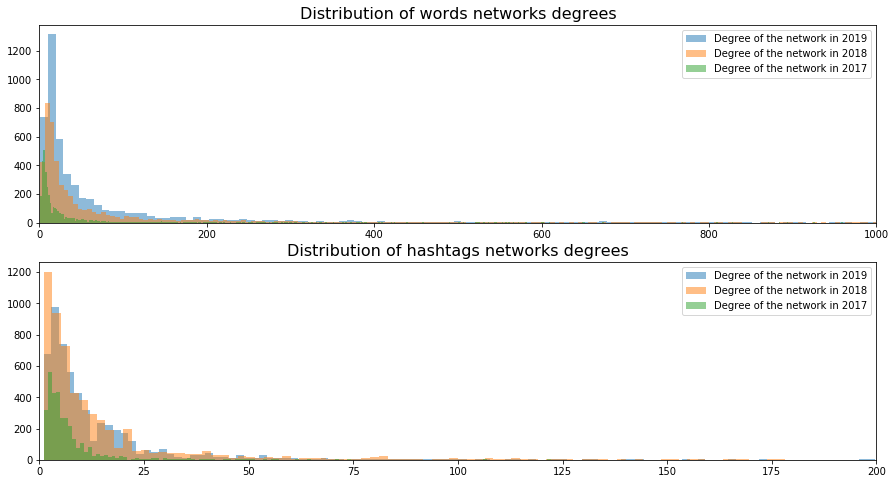

In [18]:
# Compare degrees graphically

fig, axs = plt.subplots(2, 1, figsize=(15, 8))

# Loops over network types
for i, net_type in enumerate(["words", "hashtags"]):
    # Set subplots title
    _ = axs[i].set_title('Distribution of {} networks degrees'.format(net_type), fontsize=16)
    
    # Loops over periods
    for period in [2019, 2018, 2017]:
        _ = axs[i].hist(networks[period][net_type].get_degree(), bins=2000, alpha=0.5)

    # Set legend
    _ = axs[i].legend(['Degree of the network in '+str(period) for period in [2019, 2018, 2017]])
    
# Manually set x axis limit
_ = axs[0].set_xlim(0, 1000)
_ = axs[1].set_xlim(0, 200)

#_ = plt.savefig('images/analysis/degree_hist.png')
_ = plt.show()

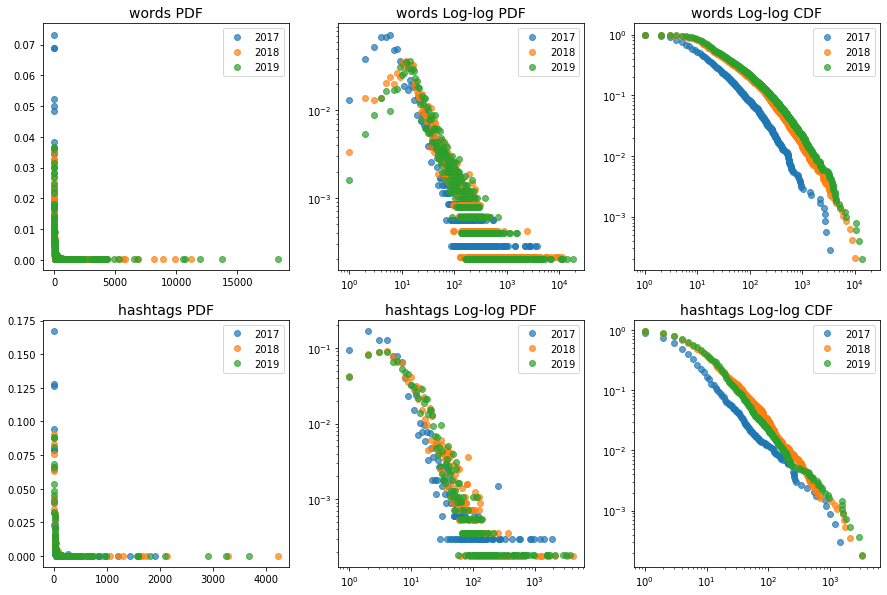

In [19]:
# Define function for plotting degree analysis
     
# Initialize plot
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Loops over network types
for j, net_type in enumerate(["words", "hashtags"]):
    
    # Set subplots titles
    _ = axs[j,0].set_title(net_type+' PDF',fontsize=14)
    _ = axs[j,1].set_title(net_type+' Log-log PDF',fontsize=14)
    _ = axs[j,2].set_title(net_type+' Log-log CDF',fontsize=14)

    # Create plot for each network
    for i, period in enumerate(networks):
        
        # Compute degree statistics
        k, count, pdf, cdf = networks[period][net_type].get_degree_stats()
        # Make plots
        _ = axs[j,0].plot(k, pdf, 'o', alpha=.7)
        _ = axs[j,1].loglog(k, pdf, 'o', alpha=.7)
        _ = axs[j,2].loglog(k, cdf, 'o', alpha=.7)

        # Show plots
        _ = [axs[j,k].legend([str(y) for y in networks], loc='upper right') for k in range(3)]
    
#_ = plt.savefig('images/analysis/degree_distr.png')
_ = plt.show()

## Scale Free Property
### Parameters Estimate

In [20]:
# Estimate power law parameters for each network

# Initialize power law parameters container (dict)
power_law_params = {}
# Loops over periods
for period in networks:
    power_law_params[period] = {}
    # Loops over network types
    for net_type in networks[period]:
        power_law_params[period][net_type] = {}

    # Set the saturation degree value
    power_law_params[period]["words"]['k_sat'] = 10 # To be set manually for each "real" network
    power_law_params[period]["hashtags"]['k_sat'] = 4
    
power_law_params[2017]["words"]["k_sat"] = 5
power_law_params[2017]["hashtags"]["k_sat"] = 2
       
    
# Compute power law parameters and store them
for period in networks:
    for net_type in networks[period]:
        # Compute parameters
        k_sat = power_law_params[period][net_type]["k_sat"]
        pl_params = networks[period][net_type].power_law(k_sat)
        # Loops over parameters and store them
        for i, param in enumerate(["k_min", "k_max", "gamma", "c", "cutoff"]):
            power_law_params[period][net_type][param] = pl_params[i]
            
# Print parameters for all the networks
for period in networks:
    print("\nTime Period:", period)
    for net_type in networks[period]:
        print("   Network Type:", net_type)
        # Store all parameters' value and name
        pl_params = power_law_params[period][net_type].items()
        # Format all the values in exponential notation and join them to the corresponding name
        line = ["{}: {:.2e}".format(*x) for x in pl_params]
        # Print all the values separated by white spaces
        print("      ", ", ".join(line))


Time Period: 2017
   Network Type: hashtags
       k_sat: 2.00e+00, k_min: 1.00e+00, k_max: 1.91e+03, gamma: 2.15e+00, c: 2.56e+00, cutoff: 2.32e+03
   Network Type: words
       k_sat: 5.00e+00, k_min: 1.00e+00, k_max: 3.74e+03, gamma: 1.98e+00, c: 4.79e+00, cutoff: 2.04e+04

Time Period: 2018
   Network Type: hashtags
       k_sat: 4.00e+00, k_min: 1.00e+00, k_max: 4.22e+03, gamma: 2.36e+00, c: 9.00e+00, cutoff: 2.26e+03
   Network Type: words
       k_sat: 1.00e+01, k_min: 1.00e+00, k_max: 1.12e+04, gamma: 1.89e+00, c: 6.93e+00, cutoff: 1.34e+05

Time Period: 2019
   Network Type: hashtags
       k_sat: 4.00e+00, k_min: 1.00e+00, k_max: 3.68e+03, gamma: 2.37e+00, c: 9.14e+00, cutoff: 2.17e+03
   Network Type: words
       k_sat: 1.00e+01, k_min: 1.00e+00, k_max: 1.83e+04, gamma: 1.79e+00, c: 4.81e+00, cutoff: 5.07e+05


### Graphical Representation

In [21]:
# Define regression lines values for either pre and post distributions

# Initialize regression lines container
regression_line = {}
for period in networks:
    regression_line[period] = {}
    for net_type in networks[period]:
        regression_line[period][net_type] = {}

# Save the regression line
# Loop over network types
for net_type in ["words", "hashtags"]:
    # Define maximum degree among all periods
    k_max = np.max([power_law_params[period][net_type]['k_max'] for period in networks])
    # Loop over periods
    for period in networks:
        # Store k_max value
        regression_line[period][net_type]["k_max"] = k_max
        # Retrieve parameters gamma and c
        gamma = power_law_params[period][net_type]['gamma']
        c = power_law_params[period][net_type]['c']
        # Compute regression line
        regression_line[period][net_type]["values"] = c * np.arange(1, k_max) ** (1 - gamma) / (gamma - 1)

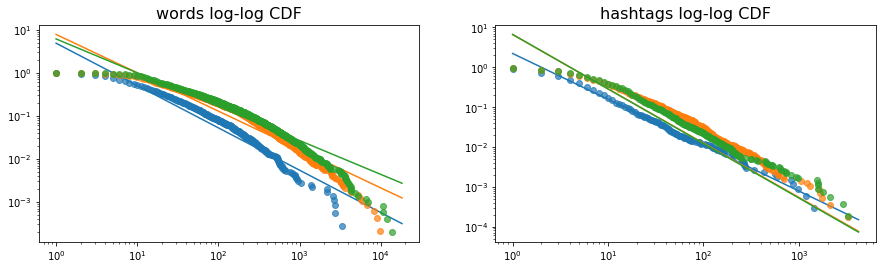

In [22]:
# Plot results
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

# Loop over network type
for i, net_type in enumerate(["words", "hashtags"]):

    _ = axs[i].set_title('{} log-log CDF'.format(net_type), fontsize=16)

    # Loop over periods
    for j, period in enumerate(networks):
        
        # Retrieve degree analysis values
        k, count, pdf, cdf = networks[period][net_type].get_degree_stats()
        # Print dots
        _ = axs[i].loglog(k, cdf, 'o', alpha=.7, color=colors[j])
        # Print regression line
        k_max = regression_line[period][net_type]["k_max"]
        _ = axs[i].loglog(np.arange(1, k_max), regression_line[period][net_type]["values"], color=colors[j])
        
# _ = plt.savefig('images/analysis/power_law.png')
_ = plt.show()

## Assortativity

### Degree assortativity

In [ ]:
# Compute assortativity coefficent for each of the networks
# for period in networks.keys():
#     print('DATA', period)
#     for net in networks[period].keys():
#         print('Assortativity {} network:'.format(net),
#               nx.degree_assortativity_coefficient(networks[period][net].net, weight = 'weight'))
#     print()

DATA 2017
Assortativity hashtags network: -0.20098559962908866
Assortativity words network: -0.11929339351025438

DATA 2018
Assortativity hashtags network: -0.12017206824361883
